In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm

import sys
sys.path.append('../utils')
from utils import *

In [4]:
data = retrieve_data()
data = data.dropna()
print(data)

          Date  ROG_Last_Price  ROG_IVOL  CFR_Last_Price  CFR_IVOL  \
0   2023-10-25          237.55   17.6858          107.00   33.0793   
1   2023-10-26          237.25   17.9504          104.45   33.5406   
2   2023-10-27          237.75   19.6028          104.40   33.4355   
3   2023-10-30          241.30   19.3503          104.75   33.1531   
4   2023-10-31          233.85   19.2518          106.90   32.7788   
..         ...             ...       ...             ...       ...   
247 2024-10-18          273.30   18.5418          127.45   28.9419   
248 2024-10-21          272.90   17.7575          126.65   31.1486   
249 2024-10-22          272.20   18.2963          126.95   30.9890   
250 2024-10-23          277.20   17.6974          126.05   31.3139   
251 2024-10-24          279.80   17.7883          128.45   31.6005   

     ZURN_Last_Price  ZURN_IVOL  Risk_Free_Rate  
0              426.4    15.7900          1.4594  
1              426.8    15.9736          1.4508  
2        

In [5]:
product_price_df = pd.read_csv(f'../data/product_price.csv')
print(product_price_df.head())

       Date Product 
0  25/10/24   98.55%
1  24/10/24   98.61%
2  23/10/24   98.55%
3  22/10/24   98.64%
4  21/10/24   98.79%


# Heston Stochastic Volatility Model 

Heston advanced:

- Multivariate approach to simulate multiple paths // done
- Calibrate model params by European options price // maybe done 
- Variance reduction and window sliding simulation

/var/folders/km/_b5m00hj0l91hg5vzm9rf92m0000gn/T/ipykernel_28079/3926583543.py:47: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.real((np.exp(-i * phi * np.log(K)) * characteristic_function(phi)) / (i * (phi + 1e-8)))).real
/var/folders/km/_b5m00hj0l91hg5vzm9rf92m0000gn/T/ipykernel_28079/3926583543.py:49: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  option_price = ( S * (0.5 + quad(integrand, 0, 100, limit=1000)[0] / np.pi) - K * np.exp(-r * T) * (0.5 + quad(integrand, 0, 100, limit=1000)[0] / np.pi))
/var/folders/km/_b5m00hj0l91hg5vzm9rf92m0000gn/T/ipykernel_28079/3926583543.py:49: RuntimeWarning: invalid value encountered in scalar subtract
  option_price = ( S * (0.5 + quad(integrand, 0, 100, limit=1000)[0] / np.pi) - K * np.exp(-r * T) * (0.5 + quad(integrand, 0, 100, limit=1000)[0] / np.pi))


Calibrated parameters for Roche: [ 3.88146351  0.19160104  0.82573542 -0.23606798  0.19160104]
Calibrated parameters for Richemont: [9.99975653e+00 1.05302816e-03 1.00044288e-01 9.99951646e-01
 1.05302816e-03]
Calibrated parameters for Zurich: [9.99771336e+00 1.05302816e-03 1.00044288e-01 9.99951646e-01
 1.05302816e-03]


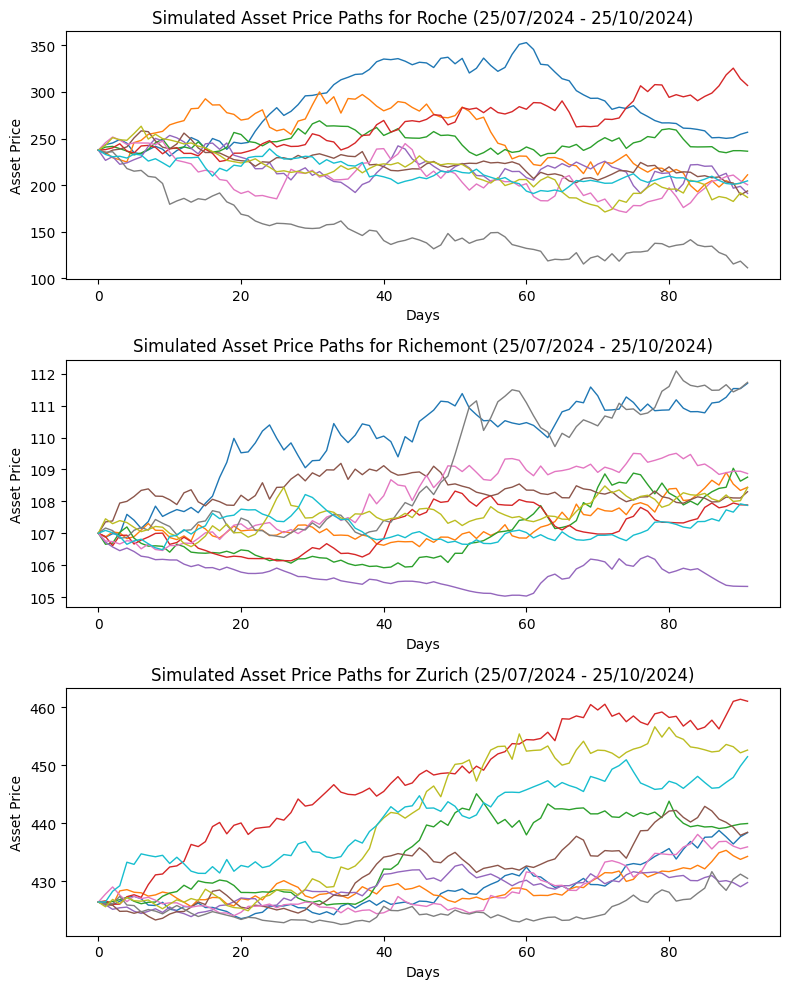

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Load your data
dates = pd.to_datetime(data['Date'])
ROG_IVOL = data['ROG_IVOL'].values / 100
CFR_IVOL = data['CFR_IVOL'].values / 100
ZURN_IVOL = data['ZURN_IVOL'].values / 100
risk_free_rate = data['Risk_Free_Rate'].values / 100

# Define initial stock prices
S0 = np.array([237.55, 107.00, 426.4])  # Initial prices for Roche, Richemont, Zurich in 2024/07/25
K = S0  # ATM options for calibration
T = 30 / 365  # 30 days to maturity
market_vols = [ROG_IVOL.mean(), CFR_IVOL.mean(), ZURN_IVOL.mean()]
r = np.nanmean(risk_free_rate)

# Initial guess and bounds for Heston parameters
initial_params = [0.5, 0.04, 0.5, -0.7, 0.04]
bounds = [(0.1, 10), (0.001, 0.5), (0.1, 2), (-1, 1), (0.001, 0.5)]

# Define a function for Heston model calibration
from scipy.integrate import quad

def heston_implied_volatility(params, S, K, T, r):
    """
    Calculates the implied volatility using the Heston model.
    """
    kappa, theta, sigma, rho, v0 = params
    # Heston characteristic function for option pricing
    def characteristic_function(phi):
        i = complex(0, 1)
        d = np.sqrt((rho * sigma * i * phi - kappa)**2 + (sigma**2) * (i * phi + phi**2))
        g = (kappa - rho * sigma * i * phi - d) / (kappa - rho * sigma * i * phi + d)
        
        C = r * i * phi * T + (kappa * theta / sigma**2) * ((kappa - rho * sigma * i * phi - d) * T - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
        D = (kappa - rho * sigma * i * phi - d) / sigma**2 * ((1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
        
        return np.exp(C + D * v0 + i * phi * np.log(S / K))
    
    # Option price integration
    def integrand(phi):
        # Adding a small constant to avoid division by zero
        return (np.real((np.exp(-i * phi * np.log(K)) * characteristic_function(phi)) / (i * (phi + 1e-8)))).real

    option_price = ( S * (0.5 + quad(integrand, 0, 100, limit=1000)[0] / np.pi) - K * np.exp(-r * T) * (0.5 + quad(integrand, 0, 100, limit=1000)[0] / np.pi))
    # Convert option price to implied volatility using Black-Scholes formula
    def black_scholes_implied_vol(S, K, T, r, option_price):
        # Initial guess for volatility
        vol_guess = 0.2
        tolerance = 1e-6
        max_iter = 100
        for _ in range(max_iter):
            d1 = (np.log(S / K) + (r + 0.5 * vol_guess**2) * T) / (vol_guess * np.sqrt(T))
            d2 = d1 - vol_guess * np.sqrt(T)
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            vega = S * norm.pdf(d1) * np.sqrt(T)
            price_diff = option_price - price
            if abs(price_diff) < tolerance:
                return vol_guess
            vol_guess += price_diff / vega  # Newton-Raphson update
        return vol_guess

    # Calculate implied volatility using Black-Scholes approximation
    implied_vol = black_scholes_implied_vol(S, K, T, r, option_price)
    return implied_vol

def heston_calibration(params, S, K, T, r, market_vol):
    """
    Objective function for Heston calibration.
    Calculates the squared difference between model and market implied volatility.
    """
    model_vol = heston_implied_volatility(params, S, K, T, r)
    return (market_vol - model_vol) ** 2


# Calibrate parameters for each asset
calibrated_parameters = []
for i, asset_name in enumerate(['Roche', 'Richemont', 'Zurich']):
    result = minimize(heston_calibration, initial_params, args=(S0[i], K[i], T, r, market_vols[i]),
                      method='Powell', bounds=bounds)
    calibrated_parameters.append(result.x)
    print(f'Calibrated parameters for {asset_name}: {result.x}')

# Simulation setup
start_date = pd.to_datetime('2024-07-25')  # Ensure this is correctly set
end_date = pd.to_datetime('2024-10-25')
n_days = (end_date - start_date).days
n_steps = n_days
T = n_days / 252
dt = 1 / 252
n_simulations = 10000

# Calibrated Heston parameters for each asset
params_ROG, params_CFR, params_ZURN = calibrated_parameters

# Function for multivariate Heston path simulation
def simulate_multivariate_paths(S0, params, r, T, dt, n_steps, n_simulations):
    n_assets = len(S0)
    S_paths = np.zeros((n_steps, n_simulations, n_assets))
    S_paths[0, :, :] = S0

    # Random number generation with variance reduction
    Z = np.random.normal(size=(n_steps, n_simulations, n_assets))
    Z = (Z - Z.mean(axis=1, keepdims=True)) / Z.std(axis=1, keepdims=True)  # Normalize for variance reduction
    

    # Simulate correlated paths for each asset
    for asset in range(n_assets):
        V0 = params[asset][-1]  # Initial volatility for each asset
        kappa, theta, sigma, rho, _ = params[asset]
        
        V_paths = np.zeros((n_steps, n_simulations))
        V_paths[0, :] = V0

        for t in range(1, n_steps):
            Z1, Z2 = Z[t, :, asset], rho * Z[t, :, asset] + np.sqrt(1 - rho**2) * np.random.normal(size=n_simulations)
            V_paths[t] = np.maximum(V_paths[t-1] + kappa * (theta - V_paths[t-1]) * dt + sigma * np.sqrt(V_paths[t-1] * dt) * Z1, 0)
            S_paths[t, :, asset] = S_paths[t-1, :, asset] * np.exp((r - 0.5 * V_paths[t]) * dt + np.sqrt(V_paths[t] * dt) * Z2)

    return S_paths

# Simulate multivariate paths
S_paths = simulate_multivariate_paths(S0, [params_ROG, params_CFR, params_ZURN], r, T, dt, n_steps, n_simulations)

# Plotting simulated paths for each asset
fig, axes = plt.subplots(3, 1, figsize=(8, 10))
for i, asset_name in enumerate(['Roche', 'Richemont', 'Zurich']):
    for j in range(10):  # Plot a few paths
        axes[i].plot(S_paths[:, j, i], lw=1)
    axes[i].set_title(f'Simulated Asset Price Paths for {asset_name} (25/07/2024 - 25/10/2024)')
    axes[i].set_xlabel('Days')
    axes[i].set_ylabel('Asset Price')

plt.tight_layout()
plt.show()


In [12]:
# Calculate the expected payoffs for the BRC product
start_date = pd.to_datetime('2024-07-25')  # Ensure this is correctly set

payoffs = np.zeros(n_simulations)
for i in range(n_simulations):
    payoffs[i] = payoff_func(
        S_paths[:, i, 0],  # Full path for ROG
        S_paths[:, i, 1],  # Full path for CFR
        S_paths[:, i, 2],  # Full path for ZURN
        start_date  # Pass the start_date parameter
    )

# Calculate the average payoff
average_payoff = np.mean(payoffs)
print('Average Payoff:', average_payoff)



Worst performance: 0.8893140477365828
Barrier event reached: False
Close above initial: 1
Worst performance: 0.8190700673187629
Barrier event reached: False
Close above initial: 1
Worst performance: 0.8659158721775435
Barrier event reached: False
Close above initial: 1
Worst performance: 0.8589604630719082
Barrier event reached: False
Close above initial: 2
Worst performance: 0.7417034724201274
Barrier event reached: False
Close above initial: 1
Worst performance: 0.7518518664934082
Barrier event reached: False
Close above initial: 1
Worst performance: 0.7777799818496035
Barrier event reached: False
Close above initial: 1
Worst performance: 0.43162365962778304
Barrier event reached: True
Close above initial: 1
Worst performance: 0.7251676480109283
Barrier event reached: False
Close above initial: 1
Worst performance: 0.7939072822487547
Barrier event reached: False
Close above initial: 1
Worst performance: 0.7886087192470418
Barrier event reached: False
Close above initial: 1
Worst perf